In [1]:
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append('../code')


from IPython.core.pylabtools import figsize
figsize(14, 7)
from pylab import *
rcParams['figure.subplot.wspace'] = 0.8
rcParams['figure.subplot.hspace'] = 0.6
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['font.size'] = 16
rcParams['axes.titlesize'] = 16
rcParams['axes.labelsize'] = 16
rcParams['xtick.labelsize'] = 14
rcParams['ytick.labelsize'] = 14
rcParams['legend.frameon'] = False


from hopfieldNetwork import hopfieldNet
from solverFile import solverClass
import numpy as np
import copy
from scipy.special import expit
import matplotlib.pyplot as plt



def to_triangular(matrix):
    return matrix[np.triu_indices_from(matrix, 1)]


def from_triangular(size, arr, diagonal_value):
    matrix = np.zeros([size, size])
    matrix[np.triu_indices_from(matrix, 1)] = arr
    matrix += matrix.T
    np.fill_diagonal(matrix, diagonal_value)
    return matrix


def dice_coefficient(p1, p2):
    p = 2 * np.sum(np.floor(0.6*(p1 + p2)))
    n = np.sum(p1)+np.sum(p2)
    return p/n


def evaluate_stability(network, patterns, average=True):
    error = np.empty(len(patterns))
    for i, p in enumerate(patterns):
        network.present_pattern(p)
        network.step(eval_epochs)
        output = netFisher.s
        error[i] = dice_coefficient(p, output)
    if average:
        return np.mean(error)
    return error

%matplotlib inline



In [2]:

ETA = 0.1  # learning rate
SPARSITY = 0.1  # number of zeros: SPARSITY = 0.1 means 10% ones and 90% zeros
IMAGE_SIZE = 10  # the size of our pattern will be (IMAGE_SIZE x IMAGE_SIZE)
print(IMAGE_SIZE**2*0.16)
eval_f = 1  # evaluation frequency (every eval_f-th iteration)
TRIALS = 1  # number of trials over which the results will be averaged
less_changed_weight_value = 0.00
# the learning rate of weights which are considered important have a
# learning rate of ETA * less_changed_weight_value
epochs_patterns_presented = 5
n_stored_patterns = 0
n_new_patterns = 15#30#20
n_tot_patterns = n_stored_patterns + n_new_patterns  # n of patterns created
NTRAIN = epochs_patterns_presented * n_new_patterns  # number of epochs
number_of_changed_values = 4600
number_of_changed_values = 4500
number_of_changed_values = int(IMAGE_SIZE*(IMAGE_SIZE-1)/2)-1200
number_of_changed_values = IMAGE_SIZE**2*(IMAGE_SIZE**2-1)//2//100*95
print(IMAGE_SIZE**2*(IMAGE_SIZE**2-1)//2,number_of_changed_values)
# number_of_changed_values_diag_0 = number_of_changed_values + IMAGE_SIZE**2/2
# the number of weigths that are changed is 2*number_of_changed_values
# (The factor of 2 is because of the symmetry of the weight matrix)
eval_epochs = 10  # how many steps are run before dice coefficient computed

# preparing patterns
solver = solverClass()
patterns = solver.create_patterns(SPARSITY, IMAGE_SIZE, n_tot_patterns)
netFisher = hopfieldNet(IMAGE_SIZE, ETA, SPARSITY)
original_patterns = copy.deepcopy(patterns)
patterns = patterns - SPARSITY

# learning patterns
p = np.random.random((IMAGE_SIZE**2, IMAGE_SIZE**2))
p = np.zeros(shape=(IMAGE_SIZE**2, IMAGE_SIZE**2))    

if n_stored_patterns>0:
    for i in range(n_stored_patterns):
        p += np.outer(patterns[:, i], patterns[:, i])
        netFisher.append_pattern(patterns[:, i], NTRAIN)
    w1 = p/n_stored_patterns
    ############################## RUN PRE-TEST ##############################
    netFisher.set_weights(w1)
    overall_error = 0
    for i in range(int(n_stored_patterns)):
        netFisher.present_pattern(original_patterns[:,i])
        netFisher.step(100)
        output = netFisher.s
        error = np.sum(original_patterns[:,i]-output)**2
        overall_error += error
    print('The overall_error is:   ', overall_error) # Error should be 0
else:
    ns = 20
    pre_patterns = solver.create_patterns(SPARSITY, IMAGE_SIZE, ns) - SPARSITY
    for i in range(ns):
        p += np.outer(pre_patterns[:, i], pre_patterns[:, i])
    w1 = p/ns/1
netFisher.set_weights(w1)



16.0
4950 4655


In [3]:

def compute_dice(ETA, c, t, func):#, t = 0.0):
    wF = np.copy(w1)
    DICE = -np.ones(shape=(NTRAIN, n_tot_patterns))
    N_PRE = 0
    NTRAIN_PRE = epochs_patterns_presented * N_PRE  # number of epochs
    pre_patterns = solver.create_patterns(SPARSITY, IMAGE_SIZE, N_PRE)
#     patterns = solver.create_patterns(SPARSITY, IMAGE_SIZE, n_tot_patterns)
#     original_patterns = copy.deepcopy(patterns)
#     patterns = patterns-SPARSITY
    all_patterns = np.hstack((pre_patterns - SPARSITY,patterns))
    w_mean = np.zeros(NTRAIN+NTRAIN_PRE)
    for epoch in range(NTRAIN+NTRAIN_PRE):
        id_pattern_taught = n_stored_patterns+epoch//epochs_patterns_presented
        pattern_taught = all_patterns[:, id_pattern_taught]

        z = (np.outer(pattern_taught, pattern_taught) - wF)

        perturbation_vector = func(wF, c, np.abs(z), t) * z * ETA
        wF = wF + perturbation_vector
        netFisher.set_weights(wF)
        w_mean[epoch] = np.mean(wF)

        # checking stability of patterns after eval_epochs iterations
        if epoch>=NTRAIN_PRE:
            DICE[epoch-NTRAIN_PRE] = evaluate_stability(  # old patterns
                netFisher, original_patterns.T[:n_tot_patterns], average=False)
    return DICE

def compute_dice_error(par,args):
    if len(par)==3:
        ETA, c, t = par
    elif len(par)==2:
        ETA, c, t = par[0], par[1], 0
    else:
        ETA, c, t = par[0], 0, 0
    return -np.sum(compute_dice(ETA, c, t, args)>0.9)


In [4]:
%%time
from scipy.optimize import minimize
from scipy import optimize

expo = lambda wF, c, z, t: np.exp(-c*np.abs(wF))
bayes = lambda wF, c, z, t: c/(c+np.abs(wF))
bayes_pow = lambda wF, c, z, t: c/(c+np.abs(wF)*(1-np.abs(wF)))
bayes_thres = lambda wF, c, z, t: c/(c+np.abs(wF))*(z>t)
w_thres  = lambda wF, c, z, t: wF<c
hopfield  = lambda wF, c, z, t: np.ones(wF.shape)
expo_thres = lambda wF, c, z, t: np.exp(-c*np.abs(wF))*(z>t)

n_new_patterns = 60
n_tot_patterns = n_stored_patterns + n_new_patterns
NTRAIN = epochs_patterns_presented * n_new_patterns
patterns = solver.create_patterns(SPARSITY, IMAGE_SIZE, n_tot_patterns)
original_patterns = copy.deepcopy(patterns)
patterns = patterns - SPARSITY

# c = optimize.fmin(compute_dice_error,(0.1,0.1,0.1),args=(bayes_thres,),disp=True) # no threshold
# c = optimize.fmin(compute_dice_error,(0.1, 1),args=(bayes,),disp=True) # no threshold
# c = optimize.fmin(compute_dice_error,(0.6, 0.1),args=(bayes_pow,),disp=True) # no threshold
c = optimize.fmin(compute_dice_error,(0.1, 30),args=(expo,),disp=True) # no threshold
# c = optimize.fmin(compute_dice_error,(0.1, 0.1), args=(w_thres,), disp=True)
# c = optimize.fmin(compute_dice_error,(0.1,), args=(hopfield,), disp=True)

print(c)


Optimization terminated successfully.
         Current function value: -4284.000000
         Iterations: 47
         Function evaluations: 109
[ 0.24528794 38.15336056]
CPU times: user 8min 22s, sys: 124 ms, total: 8min 22s
Wall time: 4min 11s


0.29364126318574924
CPU times: user 4.94 s, sys: 4 ms, total: 4.94 s
Wall time: 2.48 s


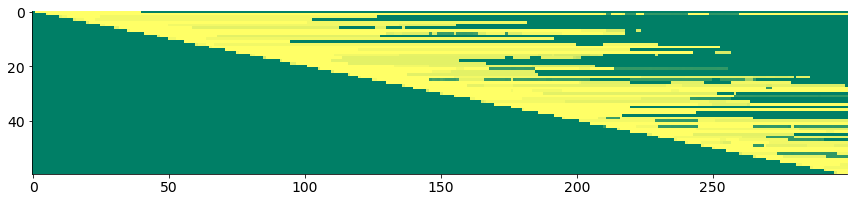

In [5]:
%%time
data = compute_dice(c[0], c[1], 0, expo)
# data = compute_dice(c[0], c[1], 0, bayes_pow)
# data = compute_dice(c[0], c[1],c[2],bayes_pow)
# data = compute_dice(c[0], c[1],0,bayes)
# data = compute_dice(c[0], 0,0,testrule)
# data = compute_dice(c[0], c[1],c[2],bayes_thres)#, c[2])
# data = compute_dice(c[0], c[1], 0, w_thres)#, c[2])
# data = compute_dice(c[0], 0, 0, hopfield)#, c[2])
fig = plt.figure(figsize=(15, 3))
ax = plt.subplot(111)
center = data
print(np.mean(center))
n,m = center.shape
im = ax.imshow(center.T,cmap=plt.cm.summer,aspect=0.2*n/m,vmin=0,vmax=1)


0.2873041488183094


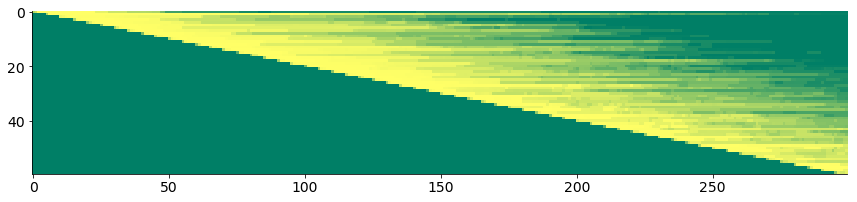

In [6]:
# compute averages

n_new_patterns = 60
n_tot_patterns = n_stored_patterns + n_new_patterns  # n of patterns created
NTRAIN = epochs_patterns_presented * n_new_patterns  # number of epochs

data = []

for i in range(10):

    patterns = solver.create_patterns(SPARSITY, IMAGE_SIZE, n_tot_patterns)
    original_patterns = copy.deepcopy(patterns)
    patterns = patterns - SPARSITY

#     data.append(compute_dice(c[0], c[1], 0, bayes))
    data.append(compute_dice(c[0], c[1], 0, expo))
#     data.append(compute_dice(c[0], c[1], 0, bayes_pow))
    # data = compute_dice(c[0], c[1], c[2], bayes_thres)
    # data = compute_dice(c[0], c[1], 1, w_thres)
#     data.append(compute_dice(c[0], 0, 0, hopfield))

fig = plt.figure(figsize=(15, 3))
ax = plt.subplot(111)
center = np.mean(data, axis=0)
print(np.mean(center))
n,m = center.shape
im = ax.imshow(center.T,cmap=plt.cm.summer,aspect=0.2*n/m,vmin=0,vmax=1)
